<img src="./resources/images/banner3.png" width="100%" alt="Encabezado MLDS">

# **Extracción de Características**
---

## **0. Integrantes del equipo de trabajo**
---

<table><thead>
  <tr>
    <th>#</th>
    <th>Integrante</th>
    <th>Documento de identidad</th>
  </tr></thead>
<tbody>
  <tr>
    <td>1</td>
    <td>Ivonne Cristina Ruiz Páez</td>
    <td>1014302058</td>  
  </tr>
  <tr>
    <td>2</td>
    <td>Diego Alejandro Feliciano Ramos</td>
    <td>1024586904</td>
  </tr>
  <tr>
    <td>3</td>
    <td>Cristhian Enrique Córdoba Trillos</td>
    <td>1030649666</td>
  </tr>
</tbody>
</table>

## **1. Selección del Embedding**
---

Para el análisis de sentimientos sobre un corpus de 50.000 documentos en inglés provenientes de redes sociales, se seleccionó la técnica de embedding FastText por su capacidad de generar representaciones distribuidas de palabras que incorporan información subléxica a través del modelado de n-gramas de caracteres. A diferencia de Word2Vec, que representa cada palabra como un vector independiente, FastText descompone las palabras en subcomponentes, lo cual permite manejar de forma más robusta errores ortográficos, abreviaciones y palabras fuera del vocabulario (OOV), fenómenos frecuentes en el lenguaje informal y no estructurado característico de las plataformas sociales. Esta propiedad resulta especialmente útil para capturar de manera más precisa el contenido semántico de los textos breves y ruidosos. Además, su eficiencia computacional lo hace adecuado para corpus de tamaño medio-grande como el presente, permitiendo generar embeddings útiles para tareas de clasificación sin incurrir en los altos costos de cómputo de modelos basados en transformers. Si bien FastText no produce embeddings contextuales, su generalización a partir de subpalabras ofrece una mejora significativa sobre técnicas tradicionales como TF-IDF o Bag-of-Words, posicionándolo como una alternativa balanceada en términos de precisión y escalabilidad para tareas de análisis de sentimientos en dominios informales como las redes sociales.

## **2. Implementación del Embedding**
---

Implemente la estrategia de embedding a partir del conjunto de datos pre-procesado. Recuerde que:

- `sklearn`: permite implementar bolsas de palabras, TF-IDF y bolsas de N-grams a partir del módulo `sklearn.feature_extraction.text`.
- `gensim`: permite implementar word2vec, fasttext y doc2vec desde `gensim.models`.
- `spacy`: permite representar textos con embeddings pre-entrenados con el atributo `vector`.

In [16]:
%pip install textblob kagglehub emoji gensim pandas numpy wordcloud

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 168 kB 11.2 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 27.7 MB/s eta 0:00:01
     |████████████████████████████████| 7.8 MB 29.9 MB/s eta 0:00:01
     |████████████████████████████████| 2.8 MB 27.0 MB/s eta 0:00:01
     |████████████████████████████████| 111 kB 33.6 MB/s eta 0:00:01
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
  Using cached kiwisolver-1.4.7-cp39-cp39-macosx_11_0_arm64.whl (64 kB)
  Using cached contourpy-1.3.0-cp39-cp39-macosx_11_0_arm64.whl (249 kB)
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [8]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from emoji import demojize

# Descargar recursos de NLTK (solo la primera vez)
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Instanciar herramientas
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Función mejorada de limpieza, normalización y tokenización
def limpiar_texto(texto):
    # Convertir a string por seguridad
    texto = str(texto)

    # 1. Normalización: convertir a minúsculas
    texto = texto.lower()

    # 2. Limpieza con Regex
    texto = re.sub(r"http\S+|www\S+|https\S+", '', texto)  # eliminar links
    texto = re.sub(r'@\w+', '', texto)                     # eliminar menciones
    texto = re.sub(r'#(\w+)', r'\1', texto)                # eliminar '#' pero conservar palabra del hashtag
    texto = re.sub(r'[^a-zA-Z\s]', '', texto)              # eliminar caracteres especiales y números

    # 3. Tokenización básica
    tokens = word_tokenize(texto)

    # 4. Filtrar stopwords y tokens muy cortos
    tokens_filtrados = [
        token for token in tokens
        if token not in stop_words and len(token) > 1
    ]

    # 5. Reemplazar emojis por su representación textual
    tokens_demojizados = [demojize(token) for token in tokens_filtrados]

    # 6. Separar ':' de los emojis textualizados para evitar que queden como un solo token
    tokens_ajustados = []
    for token in tokens_demojizados:
        if token.startswith(':') and token.endswith(':'):
            token = token.replace(":", " ")  # convertir :smile: → " smile, por ejemplo "
            token = token.strip()
            tokens_ajustados.extend(token.split())
        else:
            tokens_ajustados.append(token)

    # 7. Lematización (transformar palabras a su raíz)
    tokens_lemmatizados = [lemmatizer.lemmatize(token) for token in tokens_ajustados]

    # 8. Retornar lista de tokens (ideal para modelos como FastText en Gensim)
    return tokens_lemmatizados

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/diegof/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /Users/diegof/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/diegof/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/diegof/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [9]:
import pandas as pd
import kagglehub

# Descarga la última versión del dataset
path = kagglehub.dataset_download("suchintikasarkar/sentiment-analysis-for-mental-health")

print("Path to dataset files:", path)
# Carga la data del dataset
path = '/Users/diegof/.cache/kagglehub/datasets/suchintikasarkar/sentiment-analysis-for-mental-health/versions/1/Combined Data.csv'
df = pd.read_csv(path)

# Aplica preprocesamiento a todos los textos
corpus_tokenizado = df['statement'].apply(limpiar_texto).tolist()

/Users/diegof/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/diegof/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/diegof/.cache/kagglehub/datasets/suchintikasarkar/sentiment-analysis-for-mental-health/versions/1


In [10]:
%pip install scipy==1.10.1

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [11]:
from gensim.models import FastText

# Entrenamiento del modelo FastText
modelo_fasttext = FastText(
    sentences=corpus_tokenizado,  # lista de listas de tokens
    vector_size=100,              # dimensión de los embeddings
    window=5,                     # contexto de palabras
    min_count=2,                  # ignora palabras con frecuencia < 2
    sg=1,                         # usa Skip-gram (1) o CBOW (0)
    epochs=10                     # número de épocas de entrenamiento
)

# Guardar el modelo si quieres reutilizarlo
modelo_fasttext.save("modelo_fasttext_gensim.model")

In [13]:
import numpy as np

def vectorizar_documento(tokens, modelo):
    vectores = [modelo.wv[token] for token in tokens if token in modelo.wv]
    if vectores:
        return np.mean(vectores, axis=0)
    else:
        return np.zeros(modelo.vector_size)

In [ ]:
# Vectorizar todos los documentos preprocesados
X_vectores = np.array([vectorizar_documento(tokens, modelo_fasttext) for tokens in corpus_tokenizado])

# Ver tamaño del resultado
print(X_vectores.shape)

(53043, 100)


## **3. Exploración del Embedding**
---

Puede explorar la representación obtenida por medio de distintas técnicas de visualización o métricas:

- **Análisis de Correlaciones**: si tiene una variable objetivo, puede evaluar correlaciones entre los embeddings y dicha variable.
- **Nubes de palabras**: puede utilizar gráficos de tipo `wordcloud` para visualizar representaciones basadas en conteos
- **Distribuciones**: puede calcular histogramas o gráficos de densidad para mostrar la distribución de embeddings semánticos.

In [19]:
# Palabras similares a "happy"
modelo_fasttext.wv.most_similar("happy", topn=10)

# Similitud entre pares
print("Similitud entre happy y joyful: " + str(modelo_fasttext.wv.similarity("happy", "joyful")))
print("Similitud entre happy y angry: " + str(modelo_fasttext.wv.similarity("happy", "angry")))

Similitud entre happy y joyful: 0.6273478
Similitud entre happy y angry: 0.49169794


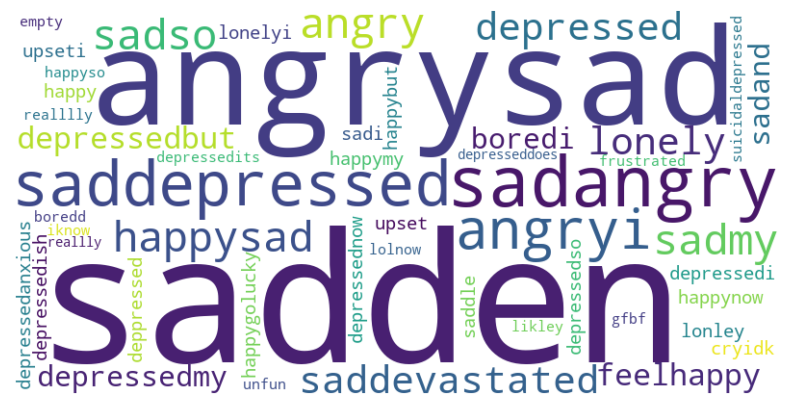

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def nube_palabras(lista_palabras):
    texto = ' '.join(lista_palabras)
    nube = WordCloud(width=800, height=400, background_color='white').generate(texto)
    plt.figure(figsize=(10, 5))
    plt.imshow(nube, interpolation='bilinear')
    plt.axis("off")
    plt.show()

palabras_similares = [w for w, _ in modelo_fasttext.wv.most_similar("sad", topn=50)]
nube_palabras(palabras_similares)

## **Créditos**

* **Profesor:** [Felipe Restrepo Calle](https://dis.unal.edu.co/~ferestrepoca/)
* **Asistentes docentes:**
    - [Juan Sebastián Lara Ramírez](https://www.linkedin.com/in/juan-sebastian-lara-ramirez-43570a214/).
* **Diseño de imágenes:**
    - [Rosa Alejandra Superlano Esquibel](mailto:rsuperlano@unal.edu.co).
* **Coordinador de virtualización:**
    - [Edder Hernández Forero](https://www.linkedin.com/in/edder-hernandez-forero-28aa8b207/).

**Universidad Nacional de Colombia** - *Facultad de Ingeniería*